![Banner](./img/AI_Special_Program_Banner.jpg)  

# Sample solutions to exercise for data cleaning
---

In the original [Kaggle Competition](https://www.kaggle.com/c/sberbank-russian-housing-market/overview) for this data set, a prediction model was to be developed for the variable `price_doc` (*target*). In order to train such a model, however, some variables must first be adjusted. This is what you will do in this exercise.

Clean up the following variables:

* **`state`**<br>
    `state` indicates the status of the apartment and should contain the values 1-4.

* **`floor` and `max_floor`**<br>
    What is the connection between `floor` and `max_floor`? Find and correct any inconsistencies.

* **`build_year`**<br>
    Check `build_year` for incorrect values and correct them in a meaningful way.

* **`life_sq`**<br>
    Remove outlier from `life_sq` and perform two different types of imputation.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./data/sberbank.csv')

## `state`

In [3]:
df['state'].unique()

array([nan,  3.,  1.,  2.,  4., 33.])

The `33rd` could be a typing error. We replace with `3.`:

In [4]:
df['state'].replace(33., 3., inplace=True)

## `floor` und `max_floor`

Check the value combinations:

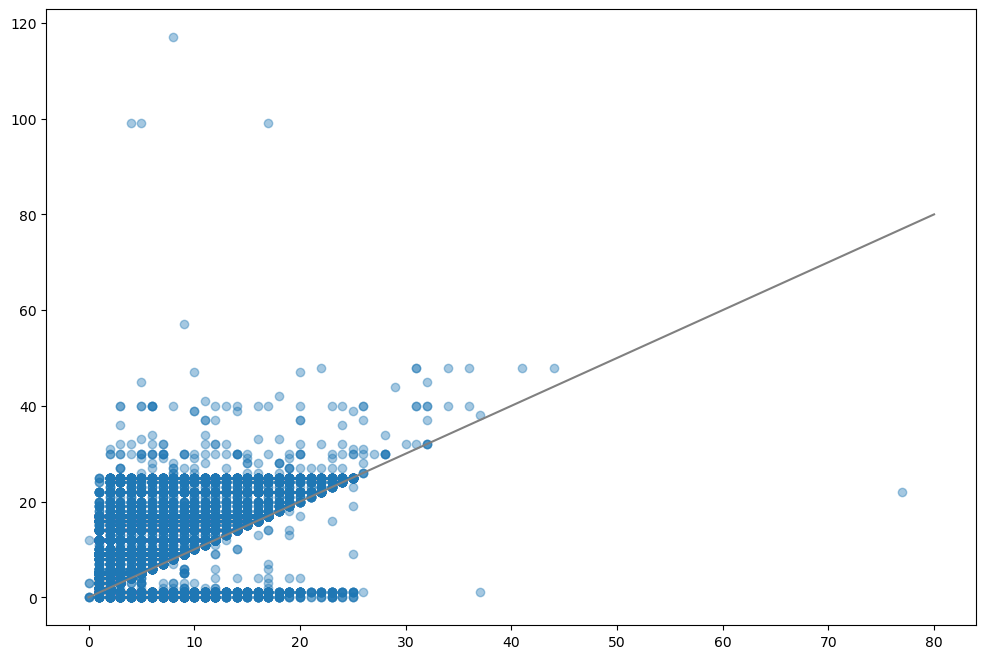

In [5]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter(x=df['floor'], y=df['max_floor'],alpha=0.4)
plt.plot([0, 80], [0, 80], color='.5');

Actually, we should not find any values below the diagonal, as the number of maximum storeys is then smaller than the number of existing storeys.

In [6]:
df.loc[df['max_floor'] < df['floor'],:].shape

(1493, 292)

This is the case for 1493 entries! We can replace the incorrect values (as well as the zero values) with `NaN`:

In [7]:
mask = (df['max_floor'] < df['floor']) | (df['max_floor']==0.0)

In [8]:
df.loc[mask,'max_floor'] = np.NaN

## `build_year`

The following values are available in `build_year`:

In [9]:
df['build_year'].dropna().astype('int64').unique()

array([    1907,     1980,     2014,     1970,     1982,     2013,
           2004,     2003,     1957,     1986,     1960,     1995,
           1979,     1975,     1987,     1962,     1969,     1993,
           1996,     1972,     2011,     1965,     2010,     1985,
           2006,     1961,     1971,     1978,     1966,     1967,
           2000,     1964,     1977,     1983,     1968,     1974,
           2008,     1959,     2007,     1984,     1976,     1997,
           1989,     1958,     1988,     2012,     1990,     1946,
           1917,     2002,     2005,     2001,     1963,     1954,
           1951,     1981,     1955,     1999,     2009,     1973,
           1994,     1998,     1992,     1950,     1956,     2015,
              0,     1932,        1,     1937,     1938,     1939,
           1991,     1934,     1935, 20052009,     1947,     1953,
           1933,     2016,     1930,     1912,     1929,        3,
           1928,     1915,     1936,     1925,     1940,     1

The following values must be replaced:

* `0` with `2000
* `1` with `2001
* `3` with `2003
* `20` with `1920
* `20052009` with `2005
* `215` with `2015
* `71` with `1971
* `4965` with `1965

In [10]:
df['build_year'].replace(0.0, 2000.0, inplace=True)
df['build_year'].replace(1.0, 2001.0, inplace=True)
df['build_year'].replace(3.0, 2003.0, inplace=True)
df['build_year'].replace(20.0, 1920.0, inplace=True)
df['build_year'].replace(20052009.0, 2005.0, inplace=True)
df['build_year'].replace(215.0, 2015.0, inplace=True)
df['build_year'].replace(71.0, 1971.0, inplace=True)
df['build_year'].replace(4965.0, 1965.0, inplace=True)

## `life_sq`

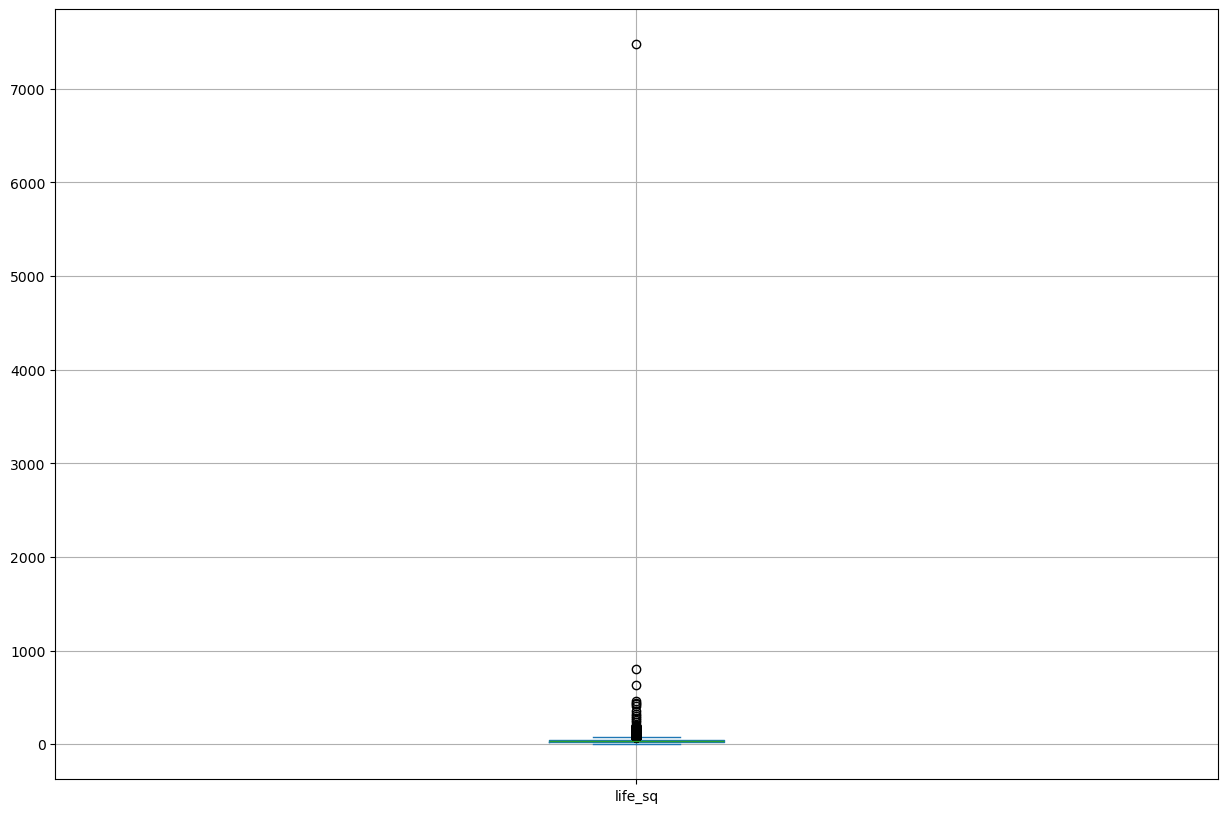

In [11]:
df['life_sq'].plot.box(figsize=(15,10), grid=True);

The boxplot shows a clear outlier with a value above 7000, which we can simply filter (we want to keep 'NaN'):

In [12]:
mask = (df['life_sq']< 1000) | (df['life_sq'].isnull())
df = df[mask]

**Imputation with Mean**

In [13]:
df_mean = df.copy()

In [14]:
mean = df_mean['life_sq'].mean(); mean

34.09424170714493

In [15]:
df_mean['life_sq'].fillna(mean, inplace=True)

In [16]:
df_mean['life_sq'].isnull().sum()

0

**KNN-Imputation**

Since we cannot use all features for KNN imputation for efficiency reasons, we want to select features that correlate with `life_sq`.

In [17]:
df_knn = df.select_dtypes(include=[np.number])

In [18]:
df_knn.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [19]:
correlations = {}
for i,feature in enumerate(df_knn.columns):
    correlations[i] = df_knn['life_sq'].corr(df_knn[feature])

In [20]:
sorted(correlations.items(), key=lambda x: x[1], reverse=True)[:10]

[(2, 1.0),
 (7, 0.5513954768950734),
 (275, 0.4148448606438824),
 (1, 0.3951990153935231),
 (6, 0.2198999416737205),
 (125, 0.1508240306510387),
 (10, 0.14751393386330344),
 (261, 0.14549050222571336),
 (259, 0.14541745192012867),
 (260, 0.14533108257930286)]

We still need to check how many `NaN` values these features have. At best, these should only be a few...

In [21]:
df_knn.iloc[:,[2,7,275,1,6,125,10,261,259,260]].isnull().sum()

life_sq                         6383
num_room                        9572
price_doc                          0
full_sq                            0
build_year                     13605
workplaces_km                      0
area_m                             0
cafe_avg_price_5000              297
cafe_sum_5000_min_price_avg      297
cafe_sum_5000_max_price_avg      297
dtype: int64

Apart from `build_year`, many values are available, so we can perform the imputation in this way.

In [22]:
from sklearn.impute import KNNImputer

In [23]:
imputer = KNNImputer(n_neighbors=2)

In [24]:
imputed = imputer.fit_transform(df_knn.iloc[:,[2,7,275,1,6,125,10,261,259,260]])

We create a new DataFrame with the filled values:

In [25]:
df_imputed = pd.DataFrame(imputed, columns=df_knn.iloc[:,[2,7,275,1,6,125,10,261,259,260]].columns)

Check whether all values have been replaced:

In [26]:
df_imputed.head()

,life_sq,num_room,price_doc,full_sq,build_year,workplaces_km,area_m,cafe_avg_price_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg
0,27.0,1.0,5850000.0,43.0,1986.0,0.884350,6.407578e+06,947.14,708.57,1185.71
1,19.0,1.5,6000000.0,34.0,1972.5,0.686252,9.589337e+06,911.31,673.81,1148.81
2,29.0,1.5,5700000.0,43.0,1963.5,1.510089,4.808270e+06,949.55,702.68,1196.43
3,50.0,4.0,13100000.0,89.0,2014.5,0.622272,1.258354e+07,1242.11,931.58,1552.63
4,77.0,3.5,16331452.0,77.0,1947.5,0.892668,8.398461e+06,1132.66,853.88,1411.45


In [27]:
df_imputed.isnull().sum()

life_sq                        0
num_room                       0
price_doc                      0
full_sq                        0
build_year                     0
workplaces_km                  0
area_m                         0
cafe_avg_price_5000            0
cafe_sum_5000_min_price_avg    0
cafe_sum_5000_max_price_avg    0
dtype: int64